In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

if project_root not in sys.path:
    print(f"Adding {project_root} to sys.path")
    sys.path.append(project_root)


Adding /vol/bitbucket/icc24/MSRGNN to sys.path


In [4]:
import pickle
import numpy as np
import pandas as pd
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from torchvision import transforms
from tqdm.auto import tqdm

/vol/venv/icc24/DGL_ENV/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# RADIO

In [5]:
try:
    from medmnist.dataset import OrganSMNIST
    # We only need to load a small part of the data to access the .info property
    info_dataset = OrganSMNIST(split='train', download=True)
    class_names_map = info_dataset.info['label']
    # Sort by the integer value of the key to ensure correct order
    sorted_class_items = sorted(class_names_map.items(), key=lambda item: int(item[0]))
    organ_class_names = [name_tuple for key, name_tuple in sorted_class_items]
    print("Successfully loaded official OrganSMNIST class names.")
except Exception as e:
    print(f"Could not load class names from MedMNIST: {e}")
    print("Using fallback generic names.")
    organ_class_names = [f"Class {i}" for i in range(11)]

print("OrganSMNIST Class Names:")
print(organ_class_names)

Successfully loaded official OrganSMNIST class names.
OrganSMNIST Class Names:
['bladder', 'femur-left', 'femur-right', 'heart', 'kidney-left', 'kidney-right', 'liver', 'lung-left', 'lung-right', 'pancreas', 'spleen']


In [6]:
from radio_data_utility_viz import RadioV1Dataset, RadioV2Dataset

## RADIO-1

In [7]:
with open('../RADIO/generated_radio_datasets_split/raven_organsmnist_v1_train.pkl', 'rb') as f:
    raven_dataset_v1_organ_train = pickle.load(f)

with open('../RADIO/generated_radio_datasets_split/raven_organsmnist_v1_val.pkl', 'rb') as f:
    raven_dataset_v1_organ_val = pickle.load(f)

with open('../RADIO/generated_radio_datasets_split/raven_organsmnist_v1_test.pkl', 'rb') as f:
    raven_dataset_v1_organ_test = pickle.load(f)

In [8]:
IMG_SIZE = 28

# --- Define Image Transformations ---
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(IMG_SIZE),  # Resize to the specified size
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomAffine(degrees=10, translate=(0.05, 0.05), scale=(0.95, 1.05), shear=5),
    transforms.ToTensor(),
])

eval_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
])

In [9]:
train_dataset = RadioV1Dataset(
    raven_dataset_v1_organ_train, # Use the split training data
    mode="test",
    transform_train=train_transform,
    transform_eval=eval_transform, # transform_eval is not used by train mode but good to pass
)

val_dataset = RadioV1Dataset(
    raven_dataset_v1_organ_val, # Use the split validation data
    mode="test",    # Set mode to "val" or "test"
    transform_train=train_transform, # Not used by val mode
    transform_eval=eval_transform,
)

test_dataset = RadioV1Dataset(
    raven_dataset_v1_organ_test, # Use the split test data
    mode="val",    # Set mode to "val" or "test"
    transform_train=train_transform, # Not used by test mode
    transform_eval=eval_transform,
)

In [ ]:
def extract_all_labels_from_dataset(dataset):
    """Helper function to iterate through a single dataset and extract labels."""
    print(f"Extracting labels from the '{dataset.mode}' dataset...")
    loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=False, num_workers=6)
    actual_class_labels = []
    target_index_labels = []
    
    for _, batch_target_index, batch_actual_class, _ in tqdm(loader, leave=False):
        actual_class_labels.extend(batch_actual_class.numpy())
        target_index_labels.extend(batch_target_index.numpy())

    return target_index_labels, actual_class_labels



In [11]:
# --- Execute the extraction for each split ---
train_target_index_labels, train_actual_labels = extract_all_labels_from_dataset(train_dataset)
val_target_index_labels, val_actual_labels = extract_all_labels_from_dataset(val_dataset)
test_target_index_labels, test_actual_labels = extract_all_labels_from_dataset(test_dataset)

# --- Combine the labels into a single "full dataset" list ---
all_actual_labels = train_actual_labels + val_actual_labels + test_actual_labels
all_target_indices = train_target_index_labels + val_target_index_labels + test_target_index_labels
total_samples = len(all_actual_labels)
print(f"\nLabel extraction complete. Analyzing a total of {total_samples} samples.")

Extracting labels from the 'test' dataset...


  0%|          | 0/35 [00:00<?, ?it/s]

Extracting labels from the 'test' dataset...


Extracting labels from the 'val' dataset...



Label extraction complete. Analyzing a total of 5500 samples.



Generating bar chart for Target Index distribution (Full Dataset)...


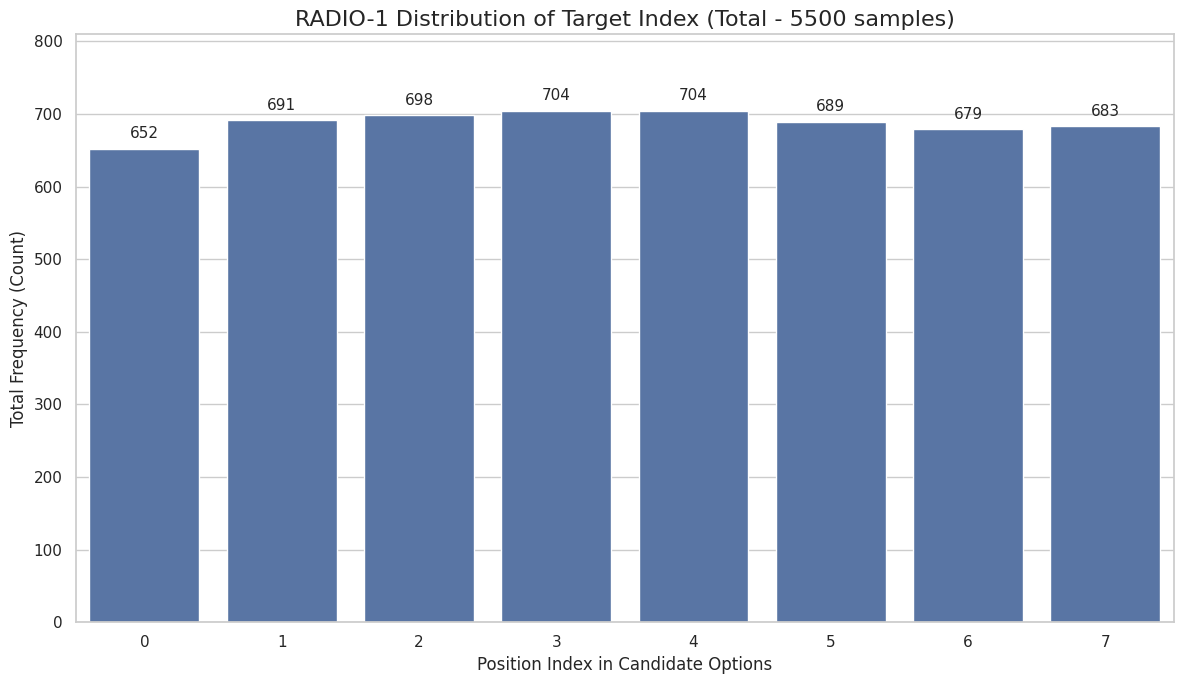

In [33]:
print("\nGenerating bar chart for Target Index distribution (Full Dataset)...")
plt.figure(figsize=(12, 7))
sns.set_theme(style="whitegrid", palette="deep")


candidate_indices = list(range(8)) 

counts = pd.Series(all_target_indices).value_counts()

counts = counts.reindex(candidate_indices, fill_value=0)

ax = sns.barplot(x=counts.index, y=counts.values)

y_max = counts.max()
for i, count in enumerate(counts):
    ax.text(i, count + y_max * 0.015, f'{count}', ha='center', va='bottom', fontsize=11)
    
plt.title(f'RADIO-1 Distribution of Target Index (Total - {total_samples} samples)', fontsize=16)
plt.ylabel('Total Frequency (Count)', fontsize=12)
plt.xlabel('Position Index in Candidate Options', fontsize=12)

plt.xticks(ticks=candidate_indices)

plt.ylim(0, y_max * 1.15)
plt.tight_layout()
plt.show()


Generating Plot 1: Distribution of Target Actual Class (Full Dataset)...


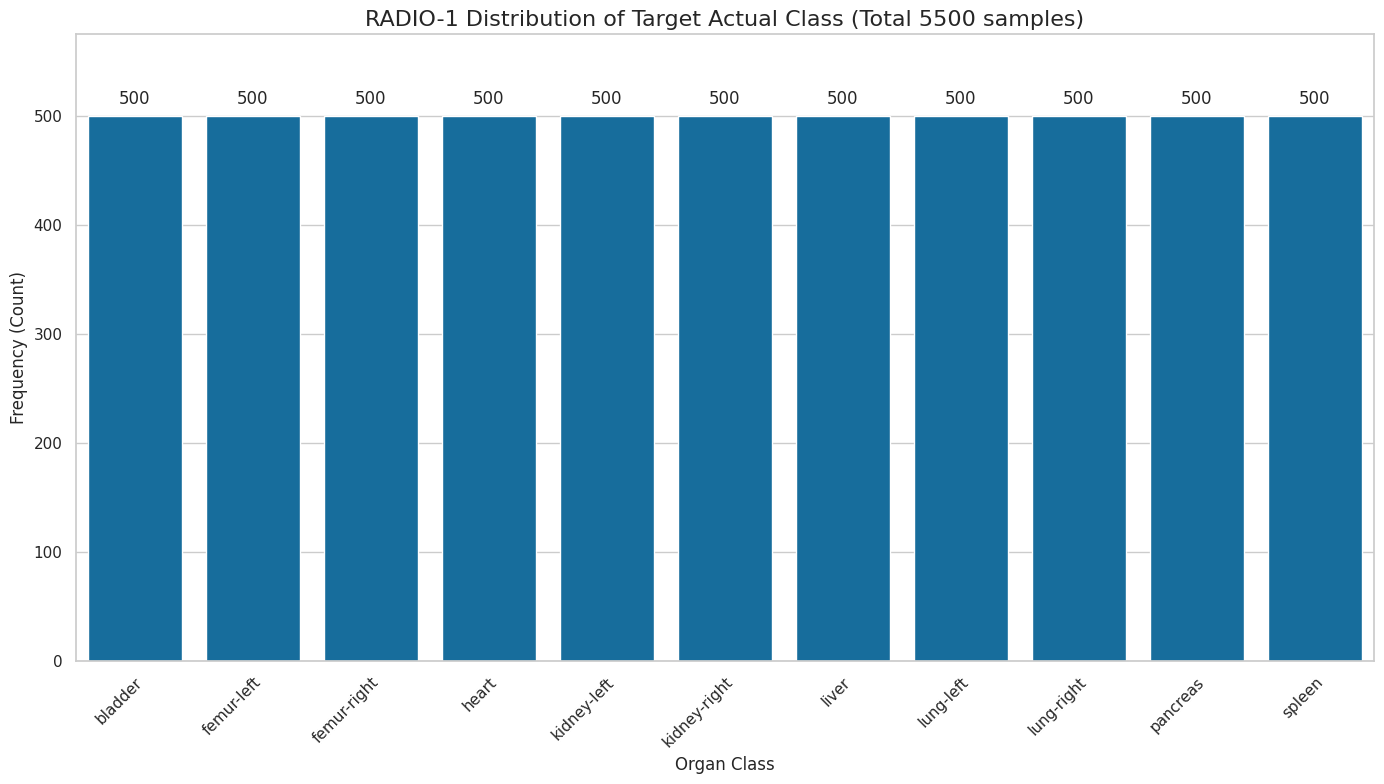

In [ ]:
print("\nGenerating Distribution of Target Actual Class (Full Dataset)...")
plt.figure(figsize=(14, 8))
# sns.set_theme(style="whitegrid", palette="flare")
sns.set_theme(style="whitegrid", palette="colorblind")

labels_as_names = [organ_class_names[i] for i in all_actual_labels]
counts = pd.Series(labels_as_names).value_counts().reindex(organ_class_names, fill_value=0)

ax = sns.barplot(x=counts.index, y=counts.values)

y_max = counts.max()
for i, count in enumerate(counts):
    ax.text(i, count + y_max * 0.015, f'{count}', ha='center', va='bottom')
    
plt.title(f'RADIO-1 Distribution of Target Actual Class (Total {total_samples} samples)', fontsize=16)
plt.ylabel('Frequency (Count)')
plt.xlabel('Organ Class')

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

plt.ylim(0, y_max * 1.15)
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import torch

def visualize_problem(problem_sample, correct_answer_index, organ_class_names, name=""):
    """
    Visualizes a single problem with the progression rule and a VISIBLE
    green box around the correct candidate answer.
    
    Args:
        problem_sample (tuple): A single item from RadioV2Dataset's __getitem__.
        correct_answer_index (int): The index of the correct answer.
        organ_class_names (list): A list of strings mapping organ indices to names.
    """
    images_tensor = problem_sample[0]
    images = images_tensor.squeeze().cpu().numpy()
    context_images = images[:8]
    candidate_images = images[8:]


    fig = plt.figure(figsize=(8, 8))
    fig.suptitle(name, fontsize=16, y=0.98)

    if len(problem_sample) == 4:
        progression_rule_indices = problem_sample[3].numpy()
        rule_as_names = [organ_class_names[i] for i in progression_rule_indices]
        rule_display_string = f"Rule: {rule_as_names[0]}, {rule_as_names[1]}, {rule_as_names[2]}"
        fig.text(0.5, 0.92, rule_display_string, ha="center", fontsize=11, style='italic', color='dimgrey')
    else:
        target_class_index = problem_sample[2].item()
        target_class_name = organ_class_names[target_class_index]
        rule_display_string = f"Target Actual Class: {target_class_name}"
        fig.text(0.5, 0.92, rule_display_string, ha="center", fontsize=11, style='italic', color='dimgrey')
    
    gs_main = gridspec.GridSpec(2, 1, figure=fig, height_ratios=[3, 1], hspace=0.3)

    # Plot the 3x3 context grid ---
    gs_context = gridspec.GridSpecFromSubplotSpec(3, 3, subplot_spec=gs_main[0], wspace=0.1, hspace=0.1)
    for i in range(8):
        row, col = divmod(i, 3)
        ax = fig.add_subplot(gs_context[row, col])
        ax.imshow(context_images[i], cmap='gray')
        ax.axis('off')
    
    ax_missing = fig.add_subplot(gs_context[2, 2])
    ax_missing.text(0.5, 0.5, '?', fontsize=40, ha='center', va='center', color='lightgrey')
    ax_missing.axis('off')

    # Plot the 8 candidate answers ---
    gs_candidates = gridspec.GridSpecFromSubplotSpec(1, 8, subplot_spec=gs_main[1], wspace=0.1)

    for i in range(len(candidate_images)):
        ax = fig.add_subplot(gs_candidates[0, i])
        ax.imshow(candidate_images[i], cmap='gray')
        
        ax.set_xticks([])
        ax.set_yticks([])

        if i == correct_answer_index:
            for spine in ax.spines.values():
                spine.set_edgecolor('limegreen')
                spine.set_linewidth(4)
                spine.set_visible(True)
        else:
            for spine in ax.spines.values():
                spine.set_visible(False)

    plt.show()

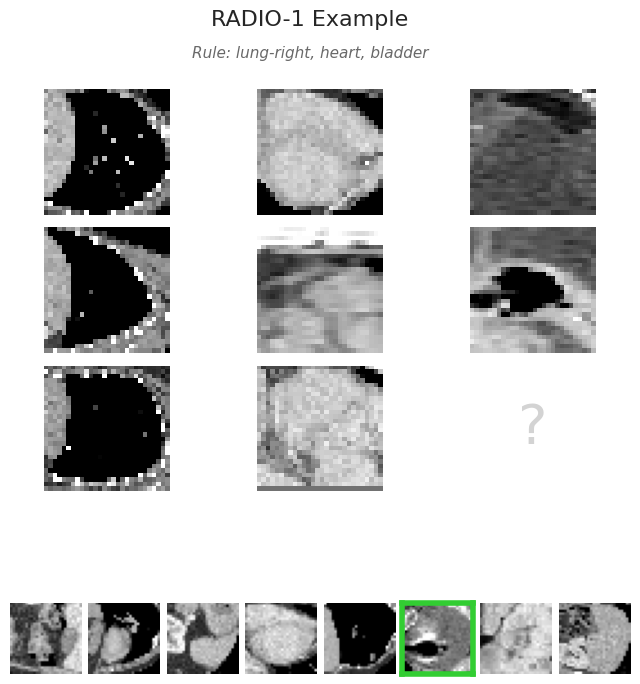

In [ ]:
sample_index = 250
problem_sample = train_dataset[sample_index]

correct_answer_index = problem_sample[1].item()

visualize_problem(problem_sample, correct_answer_index, organ_class_names, name="RADIO-1 Example")

## RADIO-2

In [16]:
with open('../RADIO/generated_radio_datasets_split/raven_organsmnist_v2_train.pkl', 'rb') as f:
    raven_dataset_v2_organ_train = pickle.load(f)

with open('../RADIO/generated_radio_datasets_split/raven_organsmnist_v2_val.pkl', 'rb') as f:
    raven_dataset_v2_organ_val = pickle.load(f)

with open('../RADIO/generated_radio_datasets_split/raven_organsmnist_v2_test.pkl', 'rb') as f:
    raven_dataset_v2_organ_test = pickle.load(f)

In [17]:
train_dataset_2 = RadioV2Dataset(
    raven_dataset_v2_organ_train, # Use the split training data
    mode="test",
    transform_train=train_transform,
    transform_eval=eval_transform, # transform_eval is not used by train mode but good to pass
)

val_dataset_2 = RadioV2Dataset(
    raven_dataset_v2_organ_val, # Use the split validation data
    mode="test",    # Set mode to "val" or "test"
    transform_train=train_transform, # Not used by val mode
    transform_eval=eval_transform,
)

test_dataset_2 = RadioV2Dataset(
    raven_dataset_v2_organ_test, # Use the split test data
    mode="val",    # Set mode to "val" or "test"
    transform_train=train_transform, # Not used by test mode
    transform_eval=eval_transform,
)

In [ ]:
def extract_all_labels_from_dataset_2(dataset):
    """Helper function to iterate through a single dataset and extract labels."""
    print(f"Extracting labels from the '{dataset.mode}' dataset...")
    loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=False, num_workers=6)
    actual_class_labels = []
    target_index_labels = []
    
    for _, batch_target_index, batch_actual_class in tqdm(loader, leave=False):
        actual_class_labels.extend(batch_actual_class.numpy())
        target_index_labels.extend(batch_target_index.numpy())

    return target_index_labels, actual_class_labels



In [ ]:
train_target_index_labels_2, train_actual_labels_2 = extract_all_labels_from_dataset_2(train_dataset_2)
val_target_index_labels_2, val_actual_labels_2 = extract_all_labels_from_dataset_2(val_dataset_2)
test_target_index_labels_2, test_actual_labels_2 = extract_all_labels_from_dataset_2(test_dataset_2)

all_actual_labels_2 = train_actual_labels_2 + val_actual_labels_2 + test_actual_labels_2
all_target_indices_2 = train_target_index_labels_2 + val_target_index_labels_2 + test_target_index_labels_2
total_samples_2 = len(all_actual_labels_2)
print(f"\nLabel extraction complete. Analyzing a total of {total_samples_2} samples.")

Extracting labels from the 'test' dataset...


  0%|          | 0/35 [00:00<?, ?it/s]

Extracting labels from the 'test' dataset...


Extracting labels from the 'val' dataset...



Label extraction complete. Analyzing a total of 5500 samples.



Generating bar chart for Target Index distribution (Full Dataset)...


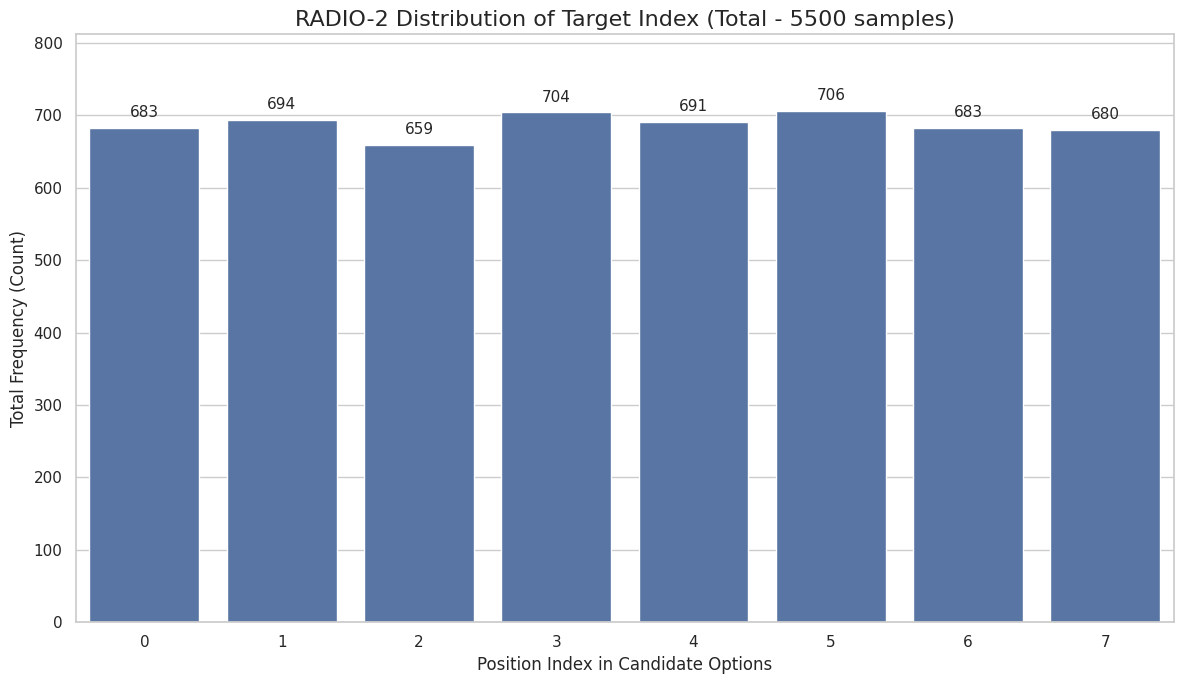

In [36]:
print("\nGenerating bar chart for Target Index distribution (Full Dataset)...")
plt.figure(figsize=(12, 7))
sns.set_theme(style="whitegrid", palette="deep")

candidate_indices = list(range(8)) 

counts = pd.Series(all_target_indices_2).value_counts()

counts = counts.reindex(candidate_indices, fill_value=0)

ax = sns.barplot(x=counts.index, y=counts.values)

y_max = counts.max()
for i, count in enumerate(counts):
    ax.text(i, count + y_max * 0.015, f'{count}', ha='center', va='bottom', fontsize=11)
    
plt.title(f'RADIO-2 Distribution of Target Index (Total - {total_samples} samples)', fontsize=16)
plt.ylabel('Total Frequency (Count)', fontsize=12)
plt.xlabel('Position Index in Candidate Options', fontsize=12)

plt.xticks(ticks=candidate_indices)

plt.ylim(0, y_max * 1.15)
plt.tight_layout()
plt.show()


Generating Plot 1: Distribution of Target Actual Class (Full Dataset)...


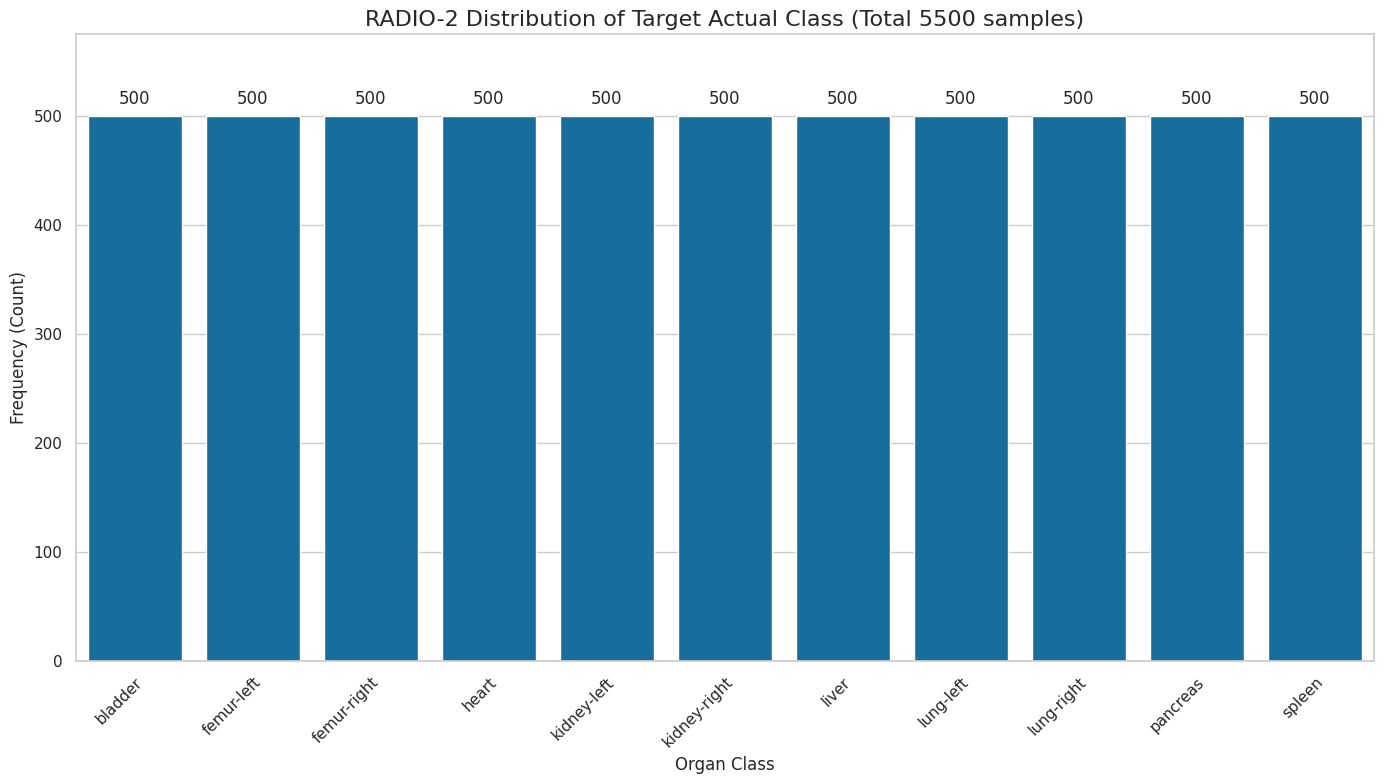

In [ ]:
print("\nGenerating Distribution of Target Actual Class (Full Dataset)...")
plt.figure(figsize=(14, 8))
sns.set_theme(style="whitegrid", palette="colorblind")

labels_as_names = [organ_class_names[i] for i in all_actual_labels_2]
counts = pd.Series(labels_as_names).value_counts().reindex(organ_class_names, fill_value=0)

ax = sns.barplot(x=counts.index, y=counts.values)

y_max = counts.max()
for i, count in enumerate(counts):
    ax.text(i, count + y_max * 0.015, f'{count}', ha='center', va='bottom')
    
plt.title(f'RADIO-2 Distribution of Target Actual Class (Total {total_samples} samples)', fontsize=16)
plt.ylabel('Frequency (Count)')
plt.xlabel('Organ Class')

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

plt.ylim(0, y_max * 1.15)
plt.tight_layout()
plt.show()

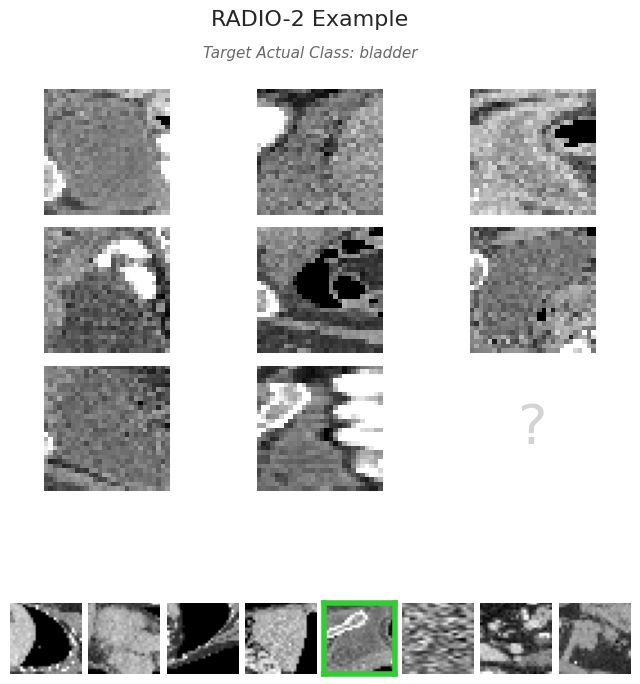

In [ ]:
sample_index = 250
problem_sample_2 = train_dataset_2[sample_index]

correct_answer_index_2 = problem_sample_2[1].item()

visualize_problem(problem_sample_2, correct_answer_index_2, organ_class_names, name="RADIO-2 Example")